In [1]:
"""Import Packages"""

import jax
import jax.numpy as jnp
from jax import grad, jit
from jaxopt import LBFGS
from jax import vmap
#from jax.scipy.optimize import minimize
#from functools import partial
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt

#import functools


# Libraries needed for SWOT images
import netCDF4
from netCDF4 import Dataset
import xarray as xr

In [2]:
# Set the random seed for reproducibility
jax.random.PRNGKey(1)

def read_data(filename, *args):
    """
    Read arrays from netcdf file.
    
    Parameters:
    ----------
    filename: input file name
    *args: strings, variables to be read as named in the netcdf file.
    
    Returns:
    -------
    arrays. The number of output arrays must be identical to the number of variables.
    """
    
    fid = Dataset(filename)
    output = []
    for entry in args:
        output.append( fid.variables[entry][:] )
    fid.close()
    
    return tuple(output)

def add_gaussian_noise(array, scale=0.03):
    """Function that add gaussian noise in original image of SSH
    
     Parameters:
    ----------
    array: SSH 
    
    Returns:
    -------
    Noisy image 
    """
    
    noise = scale * jax.random.normal(jax.random.PRNGKey(0), array.shape)
    return array + noise

def derivative(field, axis=0):
    """Compute partial derivative along given axis using second-order centered scheme.
    
    Parameters:
    ----------
    field: SSH 
    
    Returns:
    -------
    Partial derivative along the given axis
    """
    
    f = 0.5*( jnp.roll(field, -1, axis=axis) - jnp.roll(field, 1, axis=axis) ) / delta_x
    f_excluded = f[1:-1, 1:-1]
    return f_excluded

def gradient(field):
    """Compute gradient of input field.
    
    Parameters:
    ----------
    field: SSH 
    
    Returns:
    -------
    gradient of the given field
    """
    
    fx, fy = derivative(field, axis=0), derivative(field, axis=1)
    return fx, fy

@jit
def laplacian(u, delta_x, delta_y): #hxx + hyy
    """Compute laplacian of input field.
    
    Parameters:
    ----------
    field: SSH 
    
    Returns:
    -------
    laplacian of the given field
    """
    
    m, n = u.shape
    Ml_x = jnp.zeros_like(u)
    Ml_y = jnp.zeros_like(u)

    # Calculate Laplacian using finite difference method with jnp.roll 
    Ml_x = (jnp.roll(u, -1, axis=1) - 2 * u + jnp.roll(u, 1, axis=1)) / delta_x**2 # (Ui+1,j -2Ui,j +Ui-1,j)/deltax^2
    Ml_y = (jnp.roll(u, -1, axis=0) - 2 * u + jnp.roll(u, 1, axis=0)) / delta_y**2 # (Ui,j+1 -2Ui,j +Ui,j-1)/deltay^2

    Ml = Ml_x + Ml_y
    
    # Exclude the first and last row and column because we do not have the values for that
    Ml_excluded = Ml[1:-1, 1:-1]
        
    return Ml_excluded

@jit
def third_order_terms(u, delta_x, delta_y):
    """Third_order_terms = u . gradient of laplacian of SSH
    This regularization term is inspired by Quasi-Geostrophic model
    
    Parameters:
    ----------
    u: SSH 
    
    Returns:
    -------
    laplacian of the given field
    """
    
    hx   = jnp.zeros_like(u)
    hy   = jnp.zeros_like(u)
    
    hx=((jnp.roll(u,-1,axis=1) - jnp.roll(u,1,axis=1)) / (2*delta_x)) # (Ui+1,j - Ui-1,j)/2*delta_x
    hy=((jnp.roll(u,-1,axis=0) - jnp.roll(u,1,axis=0)) / (2*delta_y)) # (Ui,j+1 - Ui,j-1)/2*delta_y 
    
    hxx,hyy= gradient(laplacian(u, delta_x, delta_y)) # hxx = hxxx + hxyy & hyy = hyxx + hyyy
    
    hx = hx[2:-2, 2:-2] # Remove the boundary layers
    hy = hy[2:-2, 2:-2] # Remove the boundary layers

    # Third_order_terms = hy(hxxx + hxyy) - hx(hxxy + hyyy)
    return hy * hxx - hx * hyy 
    
@jit
def cost_function(h, h_obs, lam , delta_x, delta_y):
    """Cost function J(h) = ||h - h_obs||^2 + λ ||Δ h ||^2
    
    Parameters:
    ----------
    h: SSH that needs to be calculated (Denoised image)
    h_obs: Noisy image
    lam: Regularization parameter
    delta_x: Horizontal distance between two nodes
    delta_y: Vertical distance between two nodes
        
    Returns:
    -------
    Compute the cost function with laplacian only
    """
    
    laph = laplacian(h, delta_x, delta_y)
    term1 = jnp.sum(jnp.square(h - h_obs))
    term2 = lam * jnp.sum(jnp.square(laph))
    return term1 + term2

@jit
def cost_function_third_order_terms(h, h_obs, lam1 , lam2, delta_x, delta_y):
    """Cost function with third order terms J(h) = ||h-h_obs||^2 + λ1||Δh||^2 + λ2||hy(hxxx+hxyy) - hx(hxxy+hyyy)||^2
    
    Parameters:
    ----------
    h: SSH that needs to be calculated (Denoised image)
    h_obs: Noisy image
    lam1: Regularization parameter of laplacian
    lam2: Regularization parameter of third order terms
    delta_x: Horizontal distance between two nodes
    delta_y: Vertical distance between two nodes
        
    Returns:
    -------
    Compute the cost function with laplacian and third order terms
    """
    
    lap_h = laplacian(h, delta_x, delta_y)
    third_orderh = third_order_terms(h, delta_x, delta_y)
    term1 = jnp.sum(jnp.square(h - h_obs))
    term2 = lam1 * jnp.sum(jnp.square(lap_h))
    term3 = lam2 * jnp.sum(jnp.square(third_orderh))
    return term1 + term2 + term3

def rmse(image1, image2):
    """Function to calculate RMSE"""
    return jnp.sqrt(jnp.mean((image1 - image2)**2))

In [3]:
def splot(x_ac, x_al, ssh, c):
    """Plot the SSH 
    
    Parameters:
    ----------
    x_ac: Distance across-track
    x_al: Distance along-track
    ssh: Sea Surface Height
    c: if c=1 then it plots for SSH else it plots for laplacian of SSH
    
    Returns:
    -------
    Plot the given ssh field
    """
    if c==1:
        vmin = -0.25
        vmax = 0.05
        cmap = plt.colormaps['RdYlBu_r']
        cs = plt.pcolormesh(x_ac, x_al, ssh, cmap=cmap, vmin=vmin, vmax=vmax)
    elif c==2: 
        vmin = -0.0004
        vmax = 0.0005
        cs = plt.pcolormesh(x_ac, x_al, ssh, vmin=vmin, vmax=vmax)
    plt.colorbar(cs)
    plt.xlabel("Distance across-track (km)")
    plt.ylabel("Distance along-track (km)")
    

In [4]:
cd F:\Master Study\Research Project\Project Work February\New Cost Function\example_data

F:\Master Study\Research Project\Project Work February\New Cost Function\example_data


In [5]:
#data = xr.open_dataset(filename)

In [6]:
#data

Text(0.5, 1.0, 'Original Image')

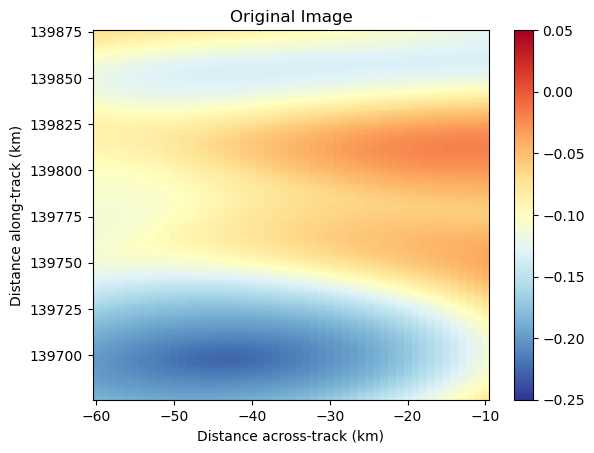

In [7]:
"""input data"""
ssh, x_al, x_ac = read_data('MED_1km_nogap_JAS12_swotFastPhase_BOX_c01_p009_v2.nc', 'ADT_model_box', 'x_al', 'x_ac')

x_ac1 = x_ac[0:len(x_ac)//2] # To consider only half of the image
x_al1 = x_al
ssh1  = ssh[:,0:len(x_ac)//2] # To consider only half of the image

#Plot Original image
splot(x_ac1, x_al1, ssh1, 1)
plt.title("Original Image")

In [8]:
# Storing the values of distance across-track and distance along-track in different varaible
x = x_ac1
y = x_al1

# h_initial = original image 
h_initial = ssh1.data #.data is used because of masked array

# Introduce Gaussian noise
h_obs = add_gaussian_noise(h_initial)

In [9]:
# Calculate delta_x 
delta_x = x[1] - x[0]

# Calculate delta_y 
delta_y = y[1] - y[0]

# Initial guess for h such that it is equal to noisy image (h_init is used in LBGS solver as an initial guess)
h_init = h_obs


Text(0.5, 1.0, 'By Adding gaussian Noise')

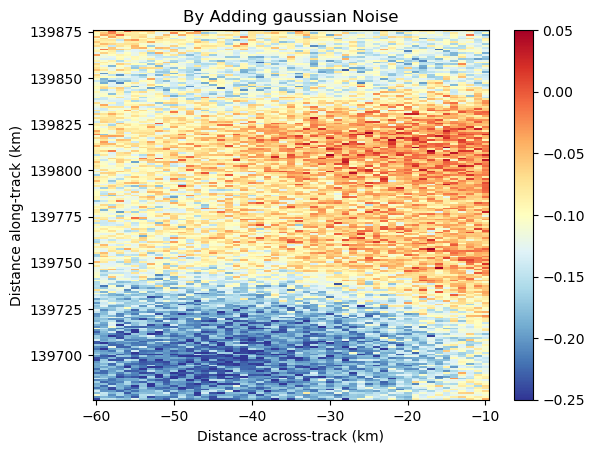

In [10]:
#Plot Noisy image
splot(x, y, h_obs, 1)
plt.title("By Adding gaussian Noise")

In [11]:
"""Run the LBFGS solver to find the minimum of cost function"""
# Regularization parameter
lam1 = 600

# Initialize the LBFGS solver 
solver = LBFGS(fun=cost_function, value_and_grad=False)

# Run the optimization
result = solver.run(h_init, h_obs, lam1, delta_x, delta_y)

# Extract the noise-free image
h_denoised = result.params

Text(0.5, 1.0, 'Denoising by using Laplacian only')

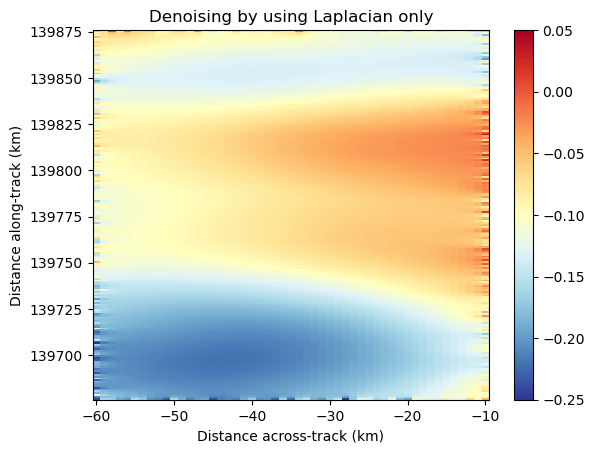

In [12]:
# Plot Denoised image with only laplacian regularization parameter 
splot(x, y, h_denoised, 1)
plt.title("Denoising by using Laplacian only")

In [13]:
"""Run the LBFGS solver to find the minimum of cost function with third order terms"""
lam1 = 100000
lam2 = 1e11

# Initialize the LBFGS solver 
solver = LBFGS(fun=cost_function_third_order_terms, value_and_grad=False)

# Run the optimization
result = solver.run(h_init, h_obs, lam1 , lam2, delta_x, delta_y)

# Extract the noise-free image
h_denoised_third_order = result.params


Text(0.5, 1.0, 'Denoising by using Laplacian & Third order terms')

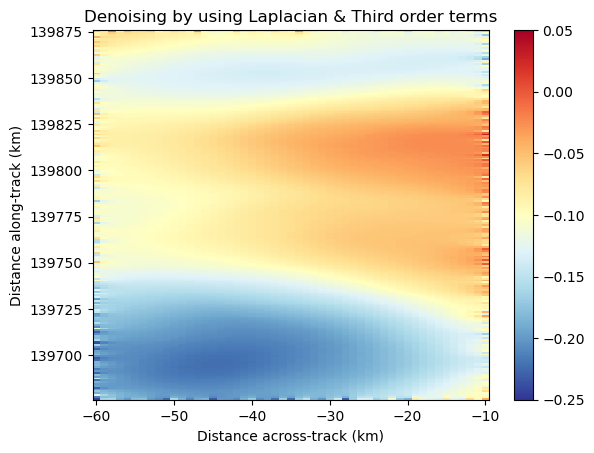

In [14]:
# Plot optimized meshgrid with third order terms
splot(x, y, h_denoised_third_order, 1)
plt.title("Denoising by using Laplacian & Third order terms")

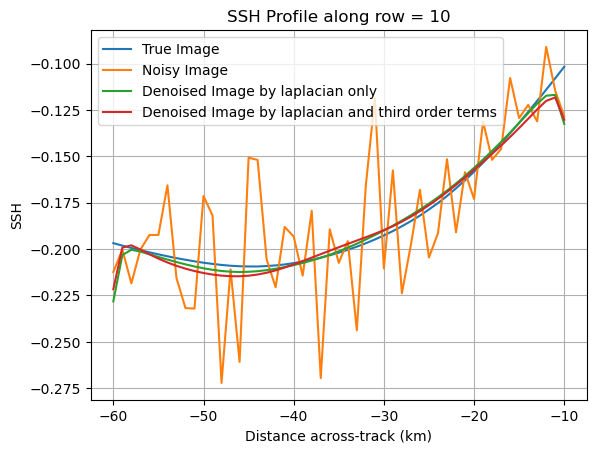

In [15]:
row = 10

# Row of Original Image
row_h_initial = h_initial[row, :]

# Row of Noisy Image 
row_h_obs = h_obs[row, :]

# Row of Denoised Image LBFGS
row_h_denoised = h_denoised[row, :]

# Row of Denoised Image LBFGS
row_h_denoised_third_order = h_denoised_third_order[row, :]

# Plot true image intensity profile
plt.plot(x, row_h_initial, label='True Image')

# Plot noisy image intensity profile
plt.plot(x, row_h_obs, label='Noisy Image')

# Plot denoised image intensity profile
plt.plot(x, row_h_denoised, label='Denoised Image by laplacian only')

# Plot denoised image intensity profile for third order values
plt.plot(x, row_h_denoised_third_order, label='Denoised Image by laplacian and third order terms')

plt.title('SSH Profile along row = {}'.format(row))
plt.xlabel('Distance across-track (km)')
plt.ylabel('SSH')
plt.legend()
plt.grid(True)
plt.show()


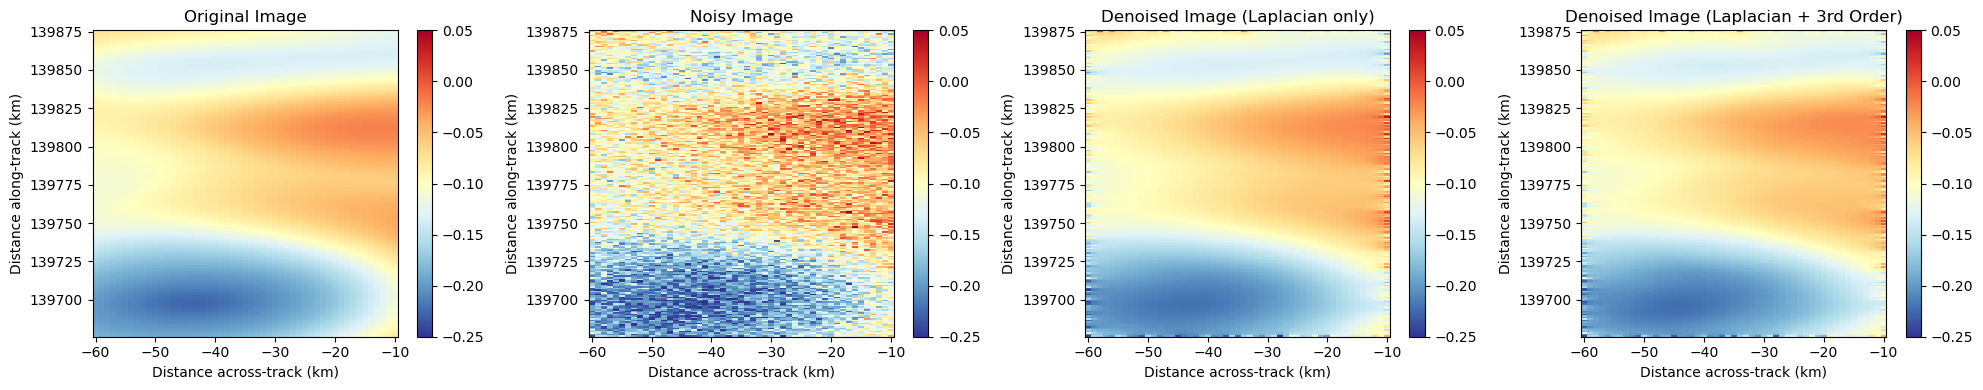

In [16]:
# Plot original image
plt.figure(figsize=(20, 4))  
plt.subplot(1, 4, 1)
splot(x, y, h_initial, 1)
plt.title('Original Image')

# Plot noisy image
plt.subplot(1, 4, 2)
splot(x, y, h_obs, 1)
plt.title('Noisy Image')

# Plot denoised image using Laplacian only
plt.subplot(1, 4, 3)
splot(x, y, h_denoised, 1)
plt.title('Denoised Image (Laplacian only)')

# Plot denoised image using Laplacian and third-order terms
plt.subplot(1, 4, 4)
splot(x, y, h_denoised_third_order, 1)
plt.title('Denoised Image (Laplacian + 3rd Order)')

plt.tight_layout()
plt.show()


In [17]:
"""Remove the boundary values to calculate RMSE"""
h_denoised_b = h_denoised[2:-2, 2:-2] # to remove the boundary values
h_initial_b = h_initial[2:-2, 2:-2] # to remove the boundary values
h_denoised_third_order_b = h_denoised_third_order[2:-2, 2:-2] # to remove the boundary values

In [18]:
# Calculate RMSE between original and noisy image
rmse_noisy = rmse(h_initial, h_obs)
print("RMSE between original and noisy image:", rmse_noisy)

# Calculate RMSE between original and denoised image using Laplacian only
rmse_denoised_laplacian = rmse(h_initial_b, h_denoised_b)
print("RMSE between original and denoised image (Laplacian only):", rmse_denoised_laplacian)

# Calculate RMSE between original and denoised image using Laplacian and third-order terms
rmse_denoised_third_order = rmse(h_initial_b, h_denoised_third_order_b)
print("RMSE between original and denoised image (Laplacian + 3rd Order):", rmse_denoised_third_order)

RMSE between original and noisy image: 0.03014873
RMSE between original and denoised image (Laplacian only): 0.0027729655
RMSE between original and denoised image (Laplacian + 3rd Order): 0.002806867


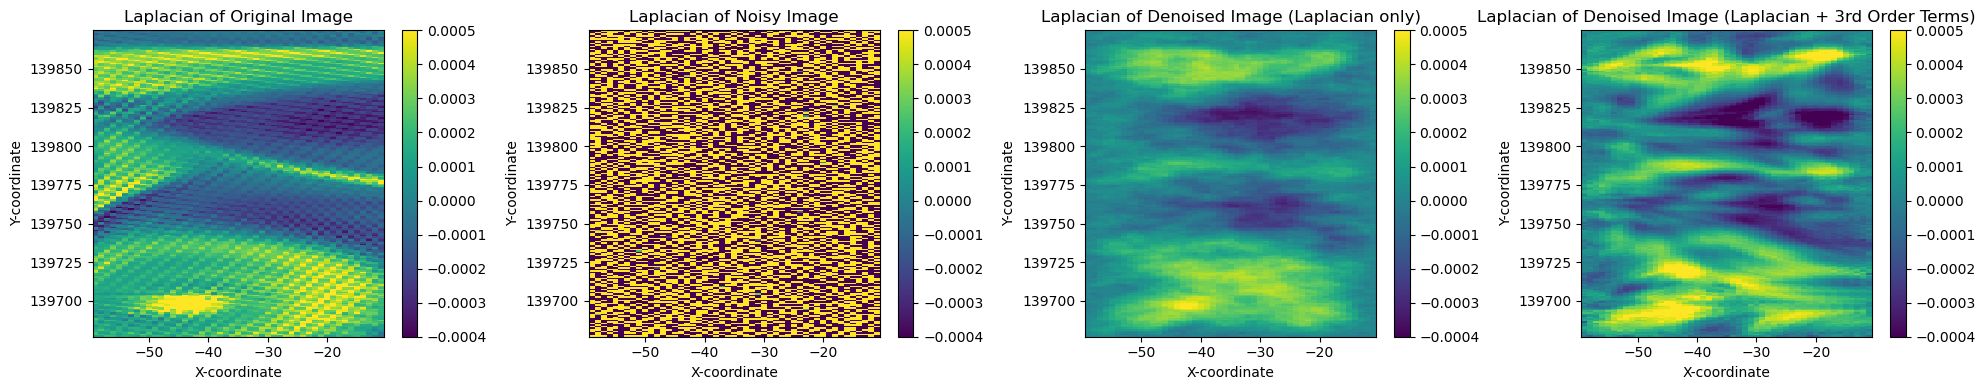

In [19]:
#To remove boundary layers
x_excluded = x[1:-1]
y_excluded = y[1:-1]

# Plot original image
plt.figure(figsize=(20, 4))  
plt.subplot(1, 4, 1)
splot(x_excluded, y_excluded, laplacian(h_initial, delta_x, delta_y), 2)
plt.title('Laplacian of Original Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# Plot noisy image
plt.subplot(1, 4, 2)
splot(x_excluded, y_excluded, laplacian(h_obs, delta_x, delta_y), 2)
plt.title('Laplacian of Noisy Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')


# Plot denoised image using Laplacian only
plt.subplot(1, 4, 3)
splot(x_excluded, y_excluded, laplacian(h_denoised, delta_x, delta_y), 2)
plt.title('Laplacian of Denoised Image (Laplacian only)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')


# Plot denoised image using Laplacian and third-order terms
plt.subplot(1, 4, 4)
splot(x_excluded, y_excluded, laplacian(h_denoised_third_order, delta_x, delta_y), 2)
plt.title('Laplacian of Denoised Image (Laplacian + 3rd Order Terms)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')


plt.tight_layout()
plt.show()


In [20]:
# Calculate RMSE between original and noisy image
rmse_noisy = rmse(laplacian(h_initial, delta_x, delta_y), laplacian(h_obs, delta_x, delta_y))
print("RMSE between laplacian of original and noisy image:", rmse_noisy)

# Calculate RMSE between original and denoised image using Laplacian only
rmse_denoised_laplacian = rmse(laplacian(h_initial_b, delta_x, delta_y), laplacian(h_denoised_b, delta_x, delta_y))
print("RMSE between laplacian of original and denoised image (Laplacian only):", rmse_denoised_laplacian)

# Calculate RMSE between original and denoised image using Laplacian and third-order terms
rmse_denoised_third_order = rmse(laplacian(h_initial_b, delta_x, delta_y), laplacian(h_denoised_third_order_b, delta_x, delta_y))
print("RMSE between laplacian of original and denoised image (Laplacian + 3rd Order):", rmse_denoised_third_order)

RMSE between laplacian of original and noisy image: 0.13556723
RMSE between laplacian of original and denoised image (Laplacian only): 0.00013760624
RMSE between laplacian of original and denoised image (Laplacian + 3rd Order): 0.00016893454


In [21]:
@jit
def rmse_second_order_cost_function(x):
    """Function to Calculate the rmse of SSH by using cost function having the term of laplacian only"""
    
    # Initializing the LBFGS solver 
    solver = LBFGS(fun=cost_function, value_and_grad=False)

    # Vectorizing the solver.run function over lam1 values
    solve_fn = vmap(lambda lam1: solver.run(h_init, h_obs, lam1, delta_x, delta_y).params)

    # Run the solver for all lam1 values simultaneously
    optimized_images = solve_fn(x)
    
    optimized_images_b = optimized_images[:, 2:-2, 2:-2]

    # Compute RMSE for all optimized images simultaneously
    rmse_values = vmap(lambda h_denoised_b: rmse(h_initial_b, h_denoised_b))(optimized_images_b)

    return rmse_values

Lamda1_series = jnp.arange(1, 1001, 10) # Lamda1 associated with laplacian only

# Computing RMSE values for all lam1 values
rmse_values = rmse_second_order_cost_function(Lamda1_series)

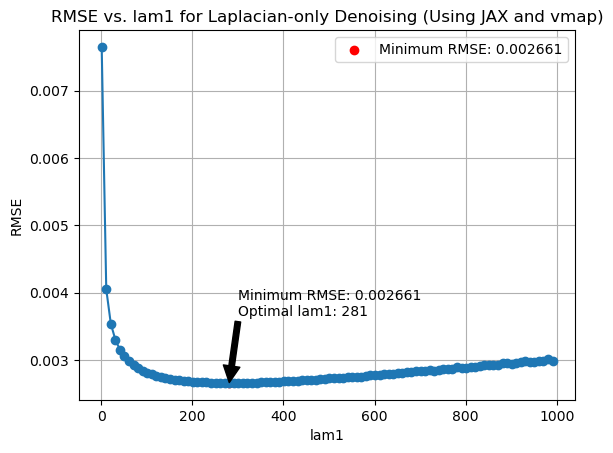

In [22]:
# Converting the list of RMSE values to a JAX array
rmse_values_array = jnp.array(rmse_values)

# Finding the index of the minimum RMSE value
min_rmse_index = jnp.argmin(rmse_values_array)

# Finding the corresponding optimal lam1 value
min_rmse_lam1 = Lamda1_series[min_rmse_index]
min_rmse_value = rmse_values[min_rmse_index]

# Plot the RMSE values against the lam1 values
plt.plot(Lamda1_series, rmse_values, marker='o')
plt.scatter(min_rmse_lam1, min_rmse_value, color='red', label=f'Minimum RMSE: {min_rmse_value:.6f}')
plt.xlabel('lam1')
plt.ylabel('RMSE')
plt.title('RMSE vs. lam1 for Laplacian-only Denoising (Using JAX and vmap)')
plt.grid(True)
plt.legend()

# Annotate the minimum RMSE value
plt.annotate(f'Minimum RMSE: {min_rmse_value:.6f}\nOptimal lam1: {min_rmse_lam1}',
             xy=(min_rmse_lam1, min_rmse_value),
             xytext=(min_rmse_lam1 +20, min_rmse_value + 0.001),
             arrowprops=dict(facecolor='black', shrink=0.005))

plt.show()


In [23]:
@jit
def rmse_third_order_cost_function(lambda1_series, lambda2_series):
    """Function to Calculate the rmse of SSH by using cost function having the term of laplacian and third order terms"""
    
    # Initialize the LBFGS solver
    solver = LBFGS(fun=cost_function_third_order_terms, value_and_grad=False)

    # Vectorize the solver.run function over lam1 and lam2 values
    solve_fn = vmap(lambda lam1, lam2: solver.run(h_init, h_obs, lam1, lam2, delta_x, delta_y).params)

    # Generate all combinations of lam1 and lam2 values
    lambda1_grid, lambda2_grid = jnp.meshgrid(lambda1_series, lambda2_series, indexing='ij')

    # Reshape lambda1 and lambda2 grids for vectorization
    lambda1_flat = lambda1_grid.flatten()
    lambda2_flat = lambda2_grid.flatten()

    # Run the solver for all lam1 and lam2 combinations simultaneously
    optimized_images = solve_fn(lambda1_flat, lambda2_flat)
    
    optimized_images_b = optimized_images[:, 2:-2, 2:-2]

    # Compute RMSE for all optimized images simultaneously
    rmse_values = vmap(lambda h_denoised_third_order_b: rmse(h_initial_b, h_denoised_third_order_b))(optimized_images_b)

    # Reshape RMSE values to match the shape of the lambda grids
    rmse_grid = rmse_values.reshape(lambda1_grid.shape)

    return rmse_grid

# Define your lambda1_series and lambda2_series
lambda1_series = jnp.array([4**n for n in range(8)], dtype=int)
lambda2_series = jnp.array([1e5 * 4**n for n in range(8)], dtype=float)

# Compute RMSE values for all combinations of lam1 and lam2 values
rmse_grid = rmse_third_order_cost_function(lambda1_series, lambda2_series)

In [24]:
# Function to generate the table
def generate_rmse_table(lambda1_series, lambda2_series, rmse_grid):
    df = pd.DataFrame(rmse_grid, index=lambda1_series, columns=lambda2_series)
    df.index.name = 'lambda1 / lambda2'
    return df

# Generate the RMSE table
rmse_df = generate_rmse_table(lambda1_series, lambda2_series, rmse_grid)

print(rmse_df)

                   1.000000e+05  4.000000e+05  1.600000e+06  6.400000e+06  \
lambda1 / lambda2                                                           
1                      0.006254      0.005973      0.005587      0.004790   
4                      0.004939      0.004703      0.004462      0.004316   
16                     0.003721      0.003687      0.003615      0.003505   
64                     0.002963      0.002961      0.002955      0.002938   
256                    0.002664      0.002664      0.002664      0.002663   
1024                   0.003016      0.003044      0.003011      0.003036   
4096                   0.004343      0.004493      0.004573      0.004513   
16384                  0.005792      0.005153      0.005604      0.005586   

                   2.560000e+07  1.024000e+08  4.096000e+08  1.638400e+09  
lambda1 / lambda2                                                          
1                      0.005291      0.008768      0.010553      0.010835  
4

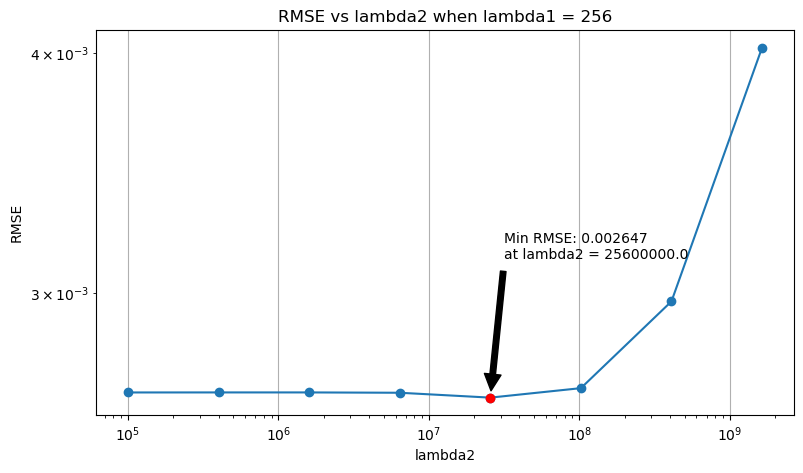

In [25]:
# Select the row where lambda1 = 256
lambda1_value = 256
rmse_row = rmse_df.loc[lambda1_value]

# Plot lambda2 vs RMSE
plt.figure(figsize=(9, 5))
plt.plot(lambda2_series, rmse_row, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda2')
plt.ylabel('RMSE')
plt.title(f'RMSE vs lambda2 when lambda1 = {lambda1_value}')
plt.grid(True)

# Find the minimum RMSE value and the corresponding lambda2 value
min_rmse = rmse_row.min()
min_lambda2 = rmse_row.idxmin()

# Highlight the point with the minimum RMSE value
plt.scatter([min_lambda2], [min_rmse], color='red', zorder=5)
plt.annotate(f'Min RMSE: {min_rmse:.6f}\nat lambda2 = {min_lambda2}',
             xy=(min_lambda2, min_rmse), xytext=(10, 100),
             textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [26]:
@jit
def rmse_lap_second_order_cost_function(x):
    """Function to Calculate the rmse of laplacian of SSH by using cost function having the term of laplacian only"""
    
    # Initialize the LBFGS solver 
    solver = LBFGS(fun=cost_function, value_and_grad=False)

    # Vectorize the solver.run function over lam1 values
    solve_fn = vmap(lambda lam1: solver.run(h_init, h_obs, lam1, delta_x, delta_y).params)

    # Run the solver for all lam1 values simultaneously
    optimized_images = solve_fn(x)
    
    # Compute RMSE for the Laplacian of SSH
    rmse_values = vmap(lambda h_denoised: rmse(laplacian(h_initial, delta_x, delta_y),
                                                          laplacian(h_denoised, delta_x, delta_y)))(optimized_images)

    return rmse_values

Lamda1_series = jnp.array([0, 1, 10, 20, 30, 40, 50, 60, 70, 80,90, 100, 200,300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 10000]) # Lamda1 associated with laplacian only

# Computing RMSE values for all lam1 values
rmse_values = rmse_lap_second_order_cost_function(Lamda1_series)

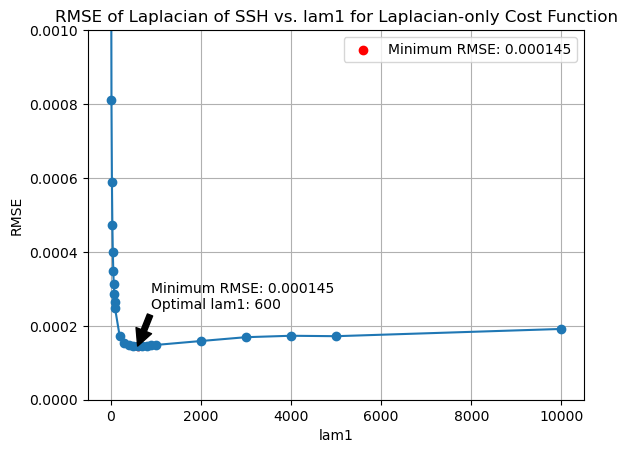

In [27]:
# Converting the list of RMSE values to a JAX array
rmse_values_array = jnp.array(rmse_values)

# Finding the index of the minimum RMSE value
min_rmse_index = jnp.argmin(rmse_values_array)

# Finding the corresponding optimal lam1 value
min_rmse_lam1 = Lamda1_series[min_rmse_index]
min_rmse_value = rmse_values[min_rmse_index]

# Plot the RMSE values against the lam1 values
plt.plot(Lamda1_series, rmse_values, marker='o')
plt.scatter(min_rmse_lam1, min_rmse_value, color='red', label=f'Minimum RMSE: {min_rmse_value:.6f}')
plt.xlabel('lam1')
plt.ylabel('RMSE')
plt.ylim(0, 10e-4)
plt.title('RMSE of Laplacian of SSH vs. lam1 for Laplacian-only Cost Function')
plt.grid(True)
plt.legend()

# Annotate the minimum RMSE value
plt.annotate(f'Minimum RMSE: {min_rmse_value:.6f}\nOptimal lam1: {min_rmse_lam1}',
             xy=(min_rmse_lam1, min_rmse_value),
             xytext=(min_rmse_lam1 +300, min_rmse_value + 0.0001),
             arrowprops=dict(facecolor='black', shrink=0.0005))

plt.show()


In [28]:
@jit
def rmse_lap_third_order_cost_function(lambda1_series_lap, lambda2_series_lap):
    """Function to Calculate the rmse of laplacian of SSH by using cost function having the term of laplacian and third order terms"""
    
    # Initialize the LBFGS solver
    solver_lap = LBFGS(fun=cost_function_third_order_terms, value_and_grad=False)

    # Vectorize the solver.run function over lam1 and lam2 values
    solve_fn_lap = vmap(lambda lam1, lam2: solver_lap.run(h_init, h_obs, lam1, lam2, delta_x, delta_y).params)

    # Generate all combinations of lam1 and lam2 values
    lambda1_grid_lap, lambda2_grid_lap = jnp.meshgrid(lambda1_series_lap, lambda2_series_lap, indexing='ij')

    # Reshape lambda1 and lambda2 grids for vectorization
    lambda1_flat_lap = lambda1_grid_lap.flatten()
    lambda2_flat_lap = lambda2_grid_lap.flatten()

    # Run the solver for all lam1 and lam2 combinations simultaneously
    optimized_images = solve_fn_lap(lambda1_flat_lap, lambda2_flat_lap)
    
    optimized_images_b = optimized_images[:, 2:-2, 2:-2]
    
    # Compute RMSE for all optimized images simultaneously
    rmse_values_lap = vmap(lambda h_denoised_third_order_b: rmse(laplacian(h_initial_b, delta_x, delta_y), laplacian(h_denoised_third_order_b, delta_x, delta_y)))(optimized_images_b)

    # Reshape RMSE values to match the shape of the lambda grids
    rmse_grid_lap = rmse_values_lap.reshape(lambda1_grid_lap.shape)

    return rmse_grid_lap

# Define your lambda1_series and lambda2_series
lambda1_series_lap = jnp.array([4**n for n in range(8)], dtype=int)
lambda2_series_lap = jnp.array([1e5 * 4**n for n in range(10)], dtype=float)

# Compute RMSE values for all combinations of lam1 and lam2 values
rmse_grid_lap = rmse_lap_third_order_cost_function(lambda1_series_lap, lambda2_series_lap)


In [29]:
# Generate the RMSE table
rmse_df_lap = generate_rmse_table(lambda1_series_lap, lambda2_series_lap, rmse_grid_lap)

print(rmse_df_lap)

                   1.000000e+05  4.000000e+05  1.600000e+06  6.400000e+06  \
lambda1 / lambda2                                                           
1                      0.006078      0.005785      0.005949      0.006829   
4                      0.002558      0.002268      0.001997      0.001832   
16                     0.000962      0.000923      0.000843      0.000736   
64                     0.000337      0.000334      0.000327      0.000308   
256                    0.000154      0.000154      0.000154      0.000153   
1024                   0.000141      0.000142      0.000141      0.000142   
4096                   0.000168      0.000171      0.000172      0.000172   
16384                  0.000197      0.000183      0.000194      0.000193   

                   2.560000e+07  1.024000e+08  4.096000e+08  1.638400e+09  \
lambda1 / lambda2                                                           
1                      0.012771      0.029362      0.037723      0.039103  

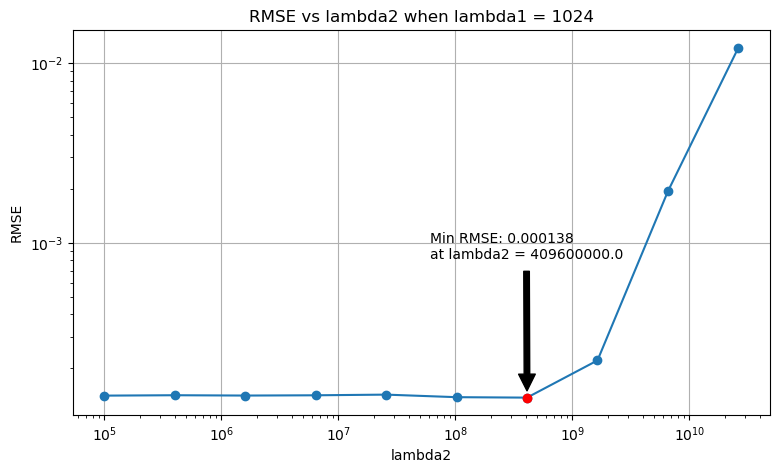

In [30]:
# Select the row where lambda1 = 1024
lambda1_value_lap = 1024
rmse_row_lap = rmse_df_lap.loc[lambda1_value_lap]

# Plot lambda2 vs RMSE
plt.figure(figsize=(9, 5))
plt.plot(lambda2_series_lap, rmse_row_lap, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda2')
plt.ylabel('RMSE')
plt.title(f'RMSE vs lambda2 when lambda1 = {lambda1_value_lap}')
plt.grid(True)

# Find the minimum RMSE value and the corresponding lambda2 value
min_rmse_lap = rmse_row_lap.min()
min_lambda2_lap = rmse_row_lap.idxmin()

# Highlight the point with the minimum RMSE value
plt.scatter([min_lambda2_lap], [min_rmse_lap], color='red', zorder=5)
plt.annotate(f'Min RMSE: {min_rmse_lap:.6f}\nat lambda2 = {min_lambda2_lap}',
             xy=(min_lambda2_lap, min_rmse_lap), xytext=(-70, 100),
             textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [31]:
"""To plot the figure of Denoised laplacian of SSH having minimum RMSE"""

# Regularization Parameters
lam1 = 1024
lam2 = 4.096000e+08

# Initialize the LBFGS solver 
solver = LBFGS(fun=cost_function_third_order_terms, value_and_grad=False)

# Run the optimization
result = solver.run(h_init, h_obs, lam1 , lam2, delta_x, delta_y)

# Extract the noise-free image
h_denoised_third_order = result.params


Text(0, 0.5, 'Y-coordinate')

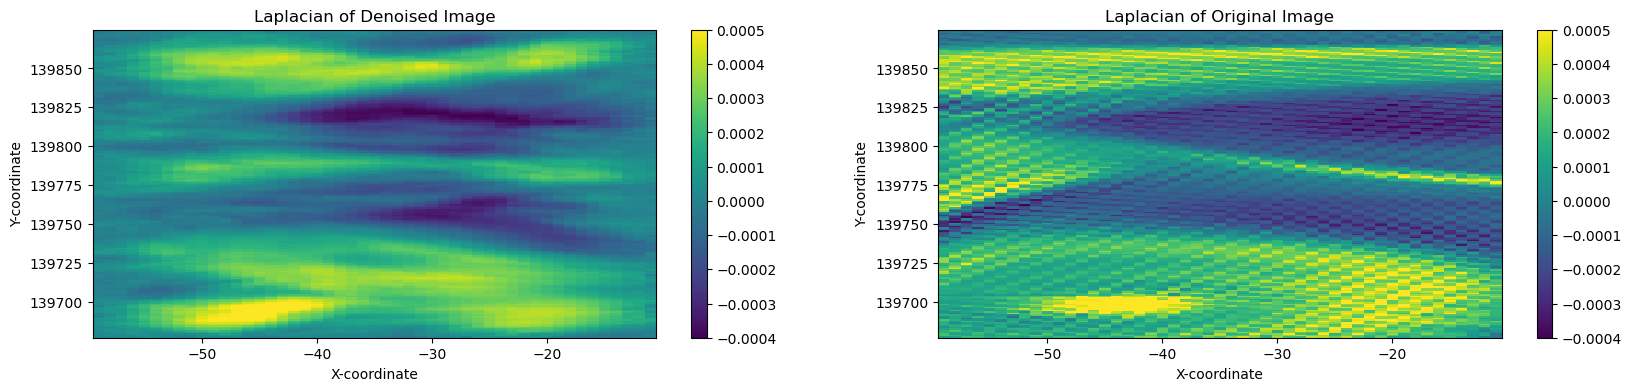

In [32]:
# Plot original image
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
splot(x_excluded, y_excluded, laplacian(h_denoised_third_order, delta_x, delta_y), 2)
plt.title('Laplacian of Denoised Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')


# Plot original image  
plt.subplot(1, 2, 2)
splot(x_excluded, y_excluded, laplacian(h_initial, delta_x, delta_y), 2)
plt.title('Laplacian of Original Image')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
